# CMSC320 Final Project: Genshin Revenue Classifier
By: Anoushka Shahani, Srishti Kalepu, Vanshika Mehta, and William Wegand

*Max requested that he be the one to grade this project.*

## Introduction to the Project
### What is Genshin Impact?
> Genshin Impact is a popular video game developed by the company *Hoyoverse* released on September 28th, 2020. This game follows the story of a Traveler and their adventures across the vast world of Teyvat in search of their lost sibling. Since release, this game was been nothing short of a success story, with over 65 million monthly players and bringing in a profit of approximately $3.7 billion since launch. Genshin Impact has also won the 2021 Game Award for Best Mobile Game and the 2022 Player's Voice Game Award. But what brings in the profit and makes the game so successful?
### How Genshin Makes Profit
> The main way in which Genshin Impact makes money is through its implementation of a '[gacha](https://www.qustodio.com/en/blog/what-are-gacha-games/)' model. In order to get new content, whether that be weapons or characters, players must 'wish' to do so. Wishing in Genshin is similar to a common lootbox system, in which players gamble to get limited-time rewards, often guaranteed a reward after a certain number of pulls. While it is possible to grind the game and save up to get new content, it is impossible to generate enough in-game currency (called Primogems) to get every single character and weapon. This is Genshin's tactic. Players can purchase currency using the in-game store with real money to then wish for the characters they want.
### Goal of the Project
> In this project, our goal is to analyze what features of limited-time five stars (the most rare type of character) make them generate more revenue as opposed to other characters. By doing this, we hope to create a model which allows us to determine whether a character will make more or less than average profit solely based on their features in order to predict the financial success of future characters. 



In [4]:
#!pip install --ignore-installed --upgrade tensorflow 
#!pip install opencv-python
#!pip install --upgrade albumentations --user
#!pip install pandas
#!pip install numpy
#!pip install matplotlib

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
import albumentations as A # used for image augmentation
from PIL import Image #used for importing images
import re
import os,glob
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard

In [6]:
# Necessary commands to run the model
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

## Data Extraction and Cleansing

Before we could get started with our actual model it was necessary to take in our dataset and make it into a format that could be accepted by our algorithm. Since we chose a niche topic, we were unable to find a pre-made dataset already on the internet. Thus to make this topic work, we had to create our own dataset. We first created this dataset in google sheets and then exported it our as a CSV. Our final dataset consisted of 7 columns: Name, Model, Region, Vision, Weapon, Revenue and Year Released. Below I will go into depth about the creation of the individual columns. 
### Name, Revenue, Year Released 
We were able to find a '[Kaggle Dataset](https://www.kaggle.com/datasets/saladyong/genshin-impact-banner-revenue)' that helped us identify the Name, Revenue and Year of Release. This dataset was a very helpful resource since it highlighted just the 5 star characters, which is the focus of our project. It also entailed the date that the banner started for us to extract out the year. There is something to note on the calculation of revenue though. When releasing characters, there is a chance that a new character is released in a rerun banner along with other characters. Thus the revenue that was present, was present for all characters on the rerun banner. This was definately an area that gave us a lot of trouble to figure out how to calculate the individual revenue for characters present in the banner. But we were able to figure out a clever technique as a workaround. Using '[Wish Tally](https://paimon.moe/wish/tally?id=300028)' website, we were able to figure out the number of times that each character on a banner was "summoned". Using this we simply added up the summons for all characters, and then divided our character in interest by that totaled number. Now we had a ratio for about how much of the money was brought in because of this character. Then to finish that up we multiplied that ratio by the revenue present on the Kaggle dataset. Important to note that we only considered the first run for characters, and didn't include any reruns they had. 

### Model
This dataset was created in very early stages of our project and thus we were still unsure about the format that the images would need to be present. Because CSV's do not allow images to be present, we were forced to separately import those in. But since our dataset was created at very early stages of the project, we as a backup still decided to include the images as their own websites. I used a website creater to manually feed in each image and thus get an individual website. Even though it is not needed for our project, it is still useful for individuals just viewing our dataset. All of the images, including the Genshin Character Folder, were manually searched and taken from '[Genshin Fandom](https://genshin-impact.fandom.com/wiki/Genshin_Impact_Wiki)'. 

### Region, Vision, Weapon
When we started the project, we were still unsure about the exact features that would have an impact on the revenue. Thus we decided to include region, vision and weapon as well to do some comparions below to decide their impact on revenue. To help fetch these items we weren't really able to find a dataset that outlined this. Thus to get all these factors we had to manually retrieve all these facts from the game itself. It is to note that all team members verified this multiple times in the game to make sure they were accurate.

After setting up all these columns we now are able to discuss each character more in depth.

In [7]:
# Reading in the data set
data = pd.read_csv('./Genshin_Dataset.csv')
data.head(24)

,Name,Model,Region,Vision,Weapon,Revenue,Year Released
0,Albedo,https://i.postimg.cc/vHqgw9cj/unnamed.jpg,Mondstadt,Geo,Sword,"$11,816,107",2021
1,Ayaka,https://i.postimg.cc/mZP9x58Q/ayaka.jpg,Inazuma,Cryo,Sword,"$16,451,006",2021
2,Ayato,https://i.postimg.cc/3JpDNDMN/ayato.jpg,Inazuma,Hydro,Sword,"$14,481,796",2022
3,Childe (Tartaglia),https://i.postimg.cc/RZBJHV9R/childe.jpg,Liyue,Hydro,Bow,"$13,443,619",2020
4,Cyno,https://i.postimg.cc/bNHN40cx/cyno.jpg,Sumeru,Electro,Polearm,"$13,797,833",2022
5,Eula,https://i.postimg.cc/NMHQDmkr/eula.jpg,Mondstadt,Cryo,Claymore,"$12,619,390",2021
6,Ganyu,https://i.postimg.cc/wM5g8zPq/ganyu.jpg,Liyue,Cryo,Bow,"$15,669,918",2021
7,Hu Tao,https://i.postimg.cc/6pW5K7tD/HuTao.jpg,Liyue,Pyro,Polearm,"$12,481,634",2021
8,Itto,https://i.postimg.cc/NGRgr803/Itto.jpg,Inazuma,Geo,Claymore,"$13,404,072",2022
9,Kazuha,https://i.postimg.cc/NFvBzFdC/kazuha.jpg,Inazuma,Anemo,Sword,"$9,807,112",2021


## Data Cleansing
The next few cells will focus on cleansing the data to be able to work with it later on. 

As stated above, the Model column ended up being useless. Thus to avoid confusion, we decided to drop the column. 

In [8]:
# Dropping unnecessary column
data = data.drop(columns = 'Model')

data.head()

,Name,Region,Vision,Weapon,Revenue,Year Released
0,Albedo,Mondstadt,Geo,Sword,"$11,816,107",2021
1,Ayaka,Inazuma,Cryo,Sword,"$16,451,006",2021
2,Ayato,Inazuma,Hydro,Sword,"$14,481,796",2022
3,Childe (Tartaglia),Liyue,Hydro,Bow,"$13,443,619",2020
4,Cyno,Sumeru,Electro,Polearm,"$13,797,833",2022


Another necessary step was to change the name of of the characters. One character Childe technically had two names present, but for clarity we decided to stick with just one name. This keeps the naming standard consistent for all the characters. 

In [9]:
# Changing extraneous value
data = data.replace('Childe (Tartaglia)', 'Childe')

The last step as a part of the data cleansing step was to change the way the Revenue column was presented. Currently, the column was present in a String format, because it included a "$" in front of the revenue. The dollar sign added nothing necessary, so we decided to use a map to eliminate the dollar sign and convert the revenue to an integer. We then created a new column 'Revenue Value' and set it equal to this new array of integer values. 

In [10]:
# Converting the Revenues to integers
revenues = data['Revenue']
revenues = revenues.map(lambda x: int(re.sub(",", "", x[1:]))) # removes $ and commas from the revenue
data['Revenue Value'] = revenues

data.head()

,Name,Region,Vision,Weapon,Revenue,Year Released,Revenue Value
0,Albedo,Mondstadt,Geo,Sword,"$11,816,107",2021,11816107
1,Ayaka,Inazuma,Cryo,Sword,"$16,451,006",2021,16451006
2,Ayato,Inazuma,Hydro,Sword,"$14,481,796",2022,14481796
3,Childe,Liyue,Hydro,Bow,"$13,443,619",2020,13443619
4,Cyno,Sumeru,Electro,Polearm,"$13,797,833",2022,13797833


## Summary Statistics

Now essentially our data is all ready to manipulate and feed into our model. As one step useful for the remainder of the analysis we thought it would be useful to create some simple summary statistics. This includes data that at a first glance would be important, including min, max, mean, median and standard deviation. For our discussion we decided to eliminate the mode, because no two characters had the same exact revenue. These numbers were printed out to help get a feel for the data before we jump into visualizations. These numbers will also be used below to help create visualizations and do analysis on them.

In [11]:
# Calculating and Displaying Summary Statistics
minimum = min(data['Revenue Value'])
maximum = max(data['Revenue Value'])
mean = data['Revenue Value'].mean()
median = data['Revenue Value'].median()
std = data['Revenue Value'].std()


print("Minimum revenue a character made: ", minimum)
print("Maximum revenue a character made: ", maximum)
print("Average revenue made across all characters: ", mean)
print("Median revenue made across all characters: ", median)
print("Standard Deviation of renevues across all characters: ", std)

Minimum revenue a character made:  6825814
Maximum revenue a character made:  33020905
Average revenue made across all characters:  15416701.625
Median revenue made across all characters:  13423845.5
Standard Deviation of renevues across all characters:  7350760.064221592


## External factors analysis
In Genshin Impact, each of the characters have features that give them their appeal. For example, a character has a region it comes from, a vision, and a weapon associated with them. All these features help in the game and further the storyline. In order to check if any of the these features have a factor in the overall revenue of the characters in addition to the aesthetic of the image, we plot scatterplots of the features against the revenue each character generated. The color of the datapoints represent one of the elements in a feature, the y-axis is the revenue, and the x-axis is the characters' names. Another factor we took into consideration was the year the character was released. 

### Revenue vs. Region
In the following scatterplot, we compare revenue with the region the character is from. Each of the distinct colors represents a unique region. The revenues for each unique region are scattered. There does not seem to be a correlation between the character's region and the revenue they generate. 

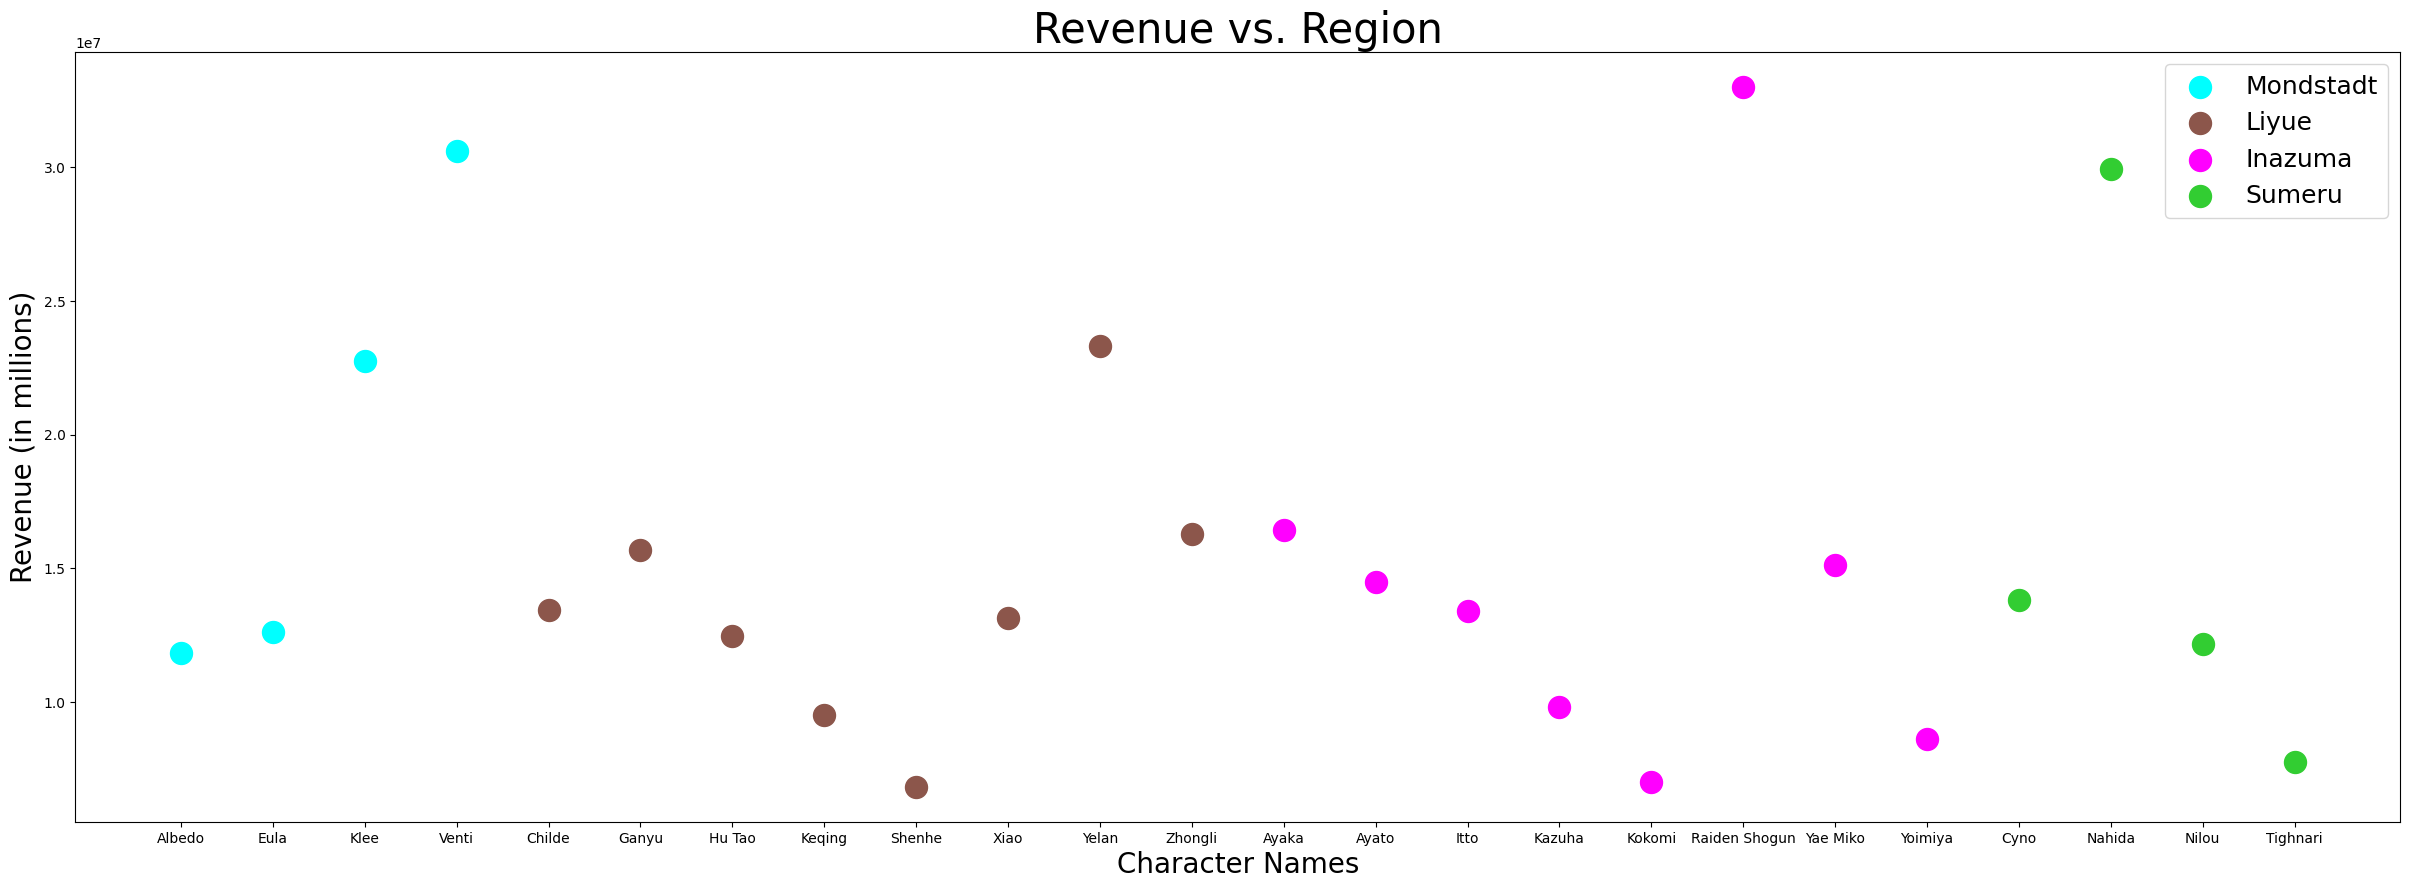

In [12]:
# Scatter plot comparing Region and Revenue
mondstadt_names = []
mondstadt_revs = []

liyue_names = []
liyue_revs = []

inazuma_names = []
inazuma_revs = []

sumeru_names = []
sumeru_revs = []

for row, col in data.iterrows():
    if col['Region'] == 'Mondstadt':
        mondstadt_names.append(col['Name'])
        mondstadt_revs.append(col['Revenue Value'])
    elif col['Region'] == 'Liyue':
        liyue_names.append(col['Name'])
        liyue_revs.append(col['Revenue Value'])
    elif col['Region'] == 'Inazuma':
        inazuma_names.append(col['Name'])
        inazuma_revs.append(col['Revenue Value'])
    else: 
        sumeru_names.append(col['Name'])
        sumeru_revs.append(col['Revenue Value'])
        
fig, ax = plt.subplots()
fig.set_figwidth(30)
fig.set_figheight(10)

ax.scatter(mondstadt_names, mondstadt_revs, c = 'aqua', label = 'Mondstadt', s = 250)
ax.scatter(liyue_names, liyue_revs, c = 'tab:brown', label = 'Liyue', s = 250)
ax.scatter(inazuma_names, inazuma_revs, c = 'fuchsia', label = 'Inazuma', s = 250)
ax.scatter(sumeru_names, sumeru_revs, c = 'limegreen', label = 'Sumeru', s = 250)

ax.set_title('Revenue vs. Region', fontsize = 30)
ax.set_xlabel('Character Names', fontsize = 20)
ax.set_ylabel('Revenue (in millions)', fontsize = 20)
ax.legend(prop = ({'size' : 18}), loc = 1)

plt.show()

### Revenue vs. Vision
In the below scatterplot, we see that the datapoints for each of the visions are scattered. There does not seem to be a correlation between a character's vision and the revenue they generated. 

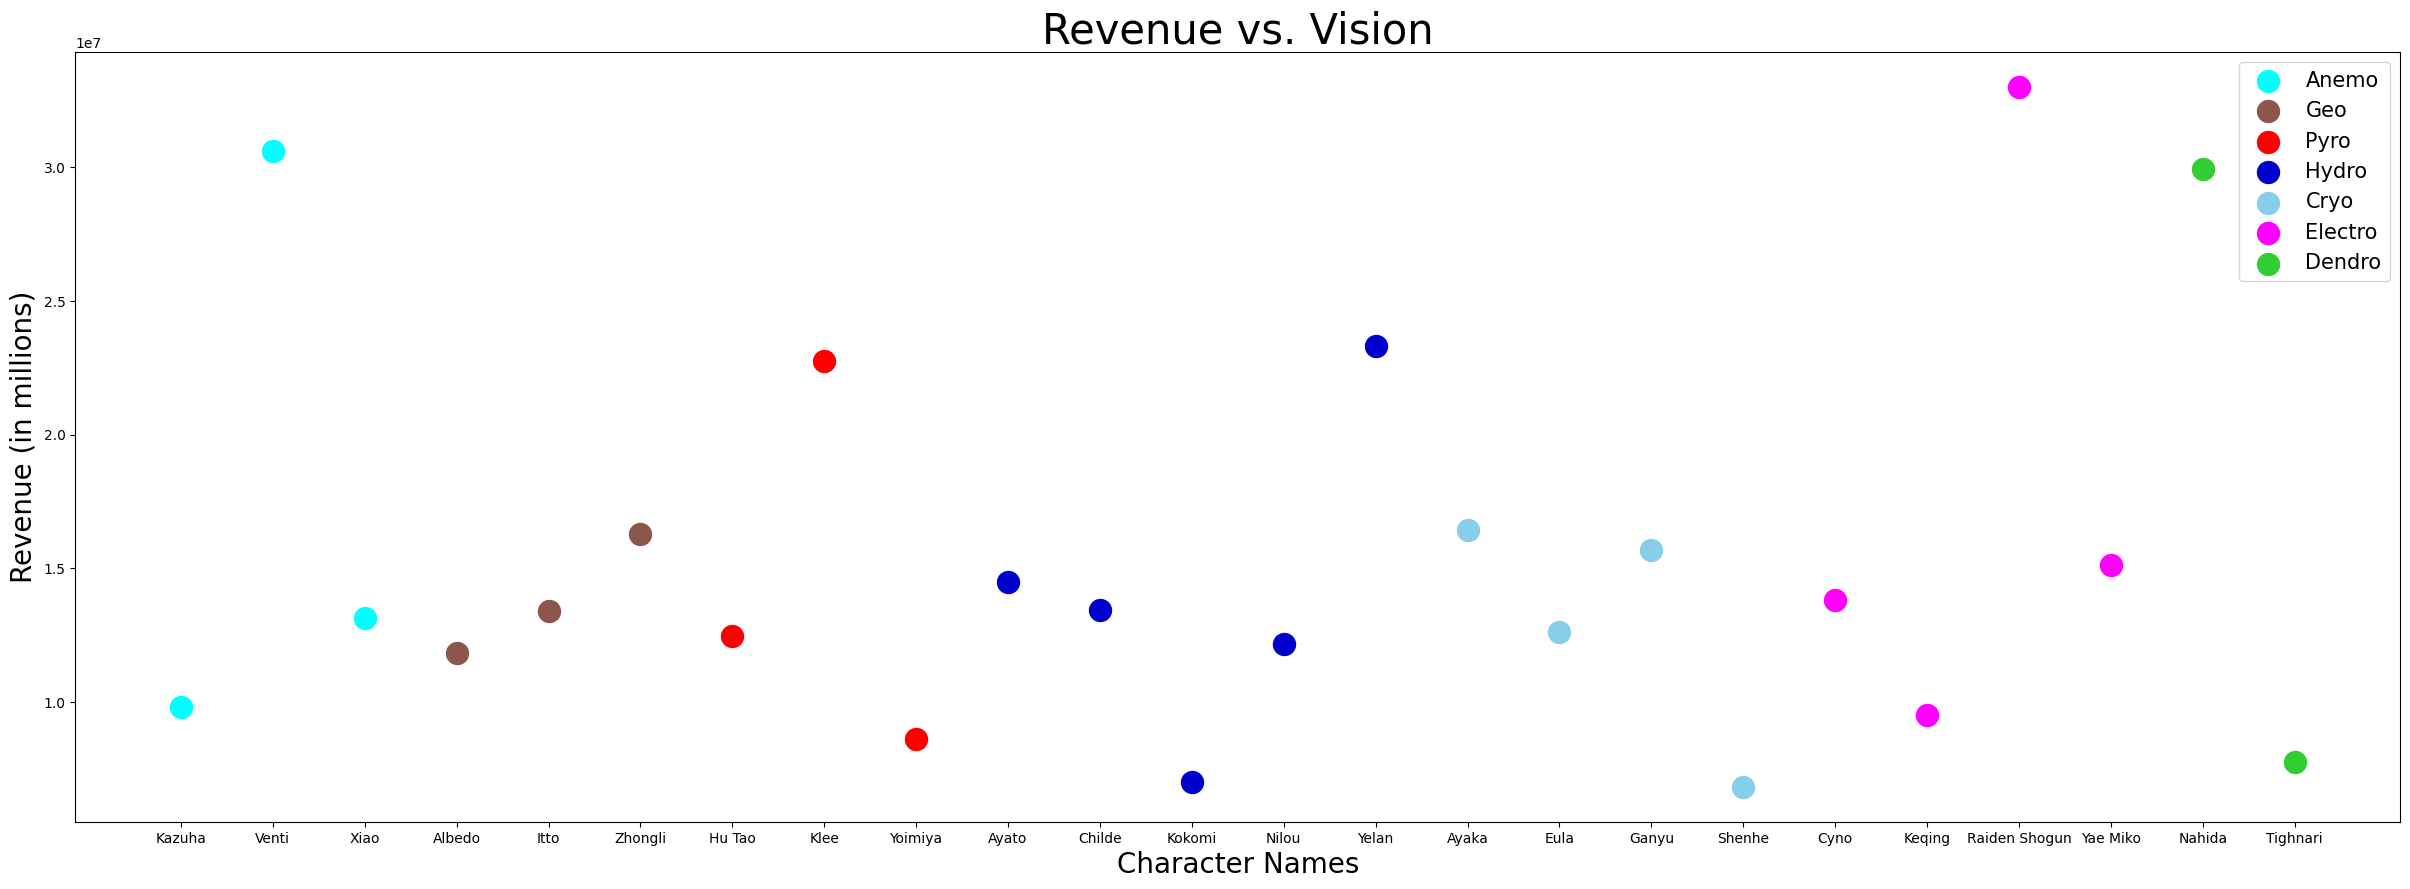

In [13]:
# Scatter plot comparing Vision and Revenue
anemo_names = []
anemo_revs = []

geo_names = []
geo_revs = []

pyro_names = []
pyro_revs = []

hydro_names = []
hydro_revs = []

cryo_names = []
cryo_revs = []

electro_names = []
electro_revs = []

dendro_names = []
dendro_revs = []

for row, col in data.iterrows():
    if col['Vision'] == 'Anemo':
        anemo_names.append(col['Name'])
        anemo_revs.append(col['Revenue Value'])
    elif col['Vision'] == 'Geo':
        geo_names.append(col['Name'])
        geo_revs.append(col['Revenue Value'])
    elif col['Vision'] == 'Pyro':
        pyro_names.append(col['Name'])
        pyro_revs.append(col['Revenue Value'])
    elif col['Vision'] == 'Hydro':
        hydro_names.append(col['Name'])
        hydro_revs.append(col['Revenue Value'])
    elif col['Vision'] == 'Cryo':
        cryo_names.append(col['Name'])
        cryo_revs.append(col['Revenue Value'])
    elif col['Vision'] == 'Electro':
        electro_names.append(col['Name'])
        electro_revs.append(col['Revenue Value'])
    else: 
        dendro_names.append(col['Name'])
        dendro_revs.append(col['Revenue Value'])
        
fig, ax = plt.subplots()
fig.set_figwidth(30)
fig.set_figheight(10)

ax.scatter(anemo_names, anemo_revs, c = 'aqua', label = 'Anemo', s = 250)
ax.scatter(geo_names, geo_revs, c = 'tab:brown', label = 'Geo', s = 250)
ax.scatter(pyro_names, pyro_revs, c = 'red', label = 'Pyro', s = 250)
ax.scatter(hydro_names, hydro_revs, c = 'mediumblue', label = 'Hydro', s = 250)
ax.scatter(cryo_names, cryo_revs, c = 'skyblue', label = 'Cryo', s = 250)
ax.scatter(electro_names, electro_revs, c = 'fuchsia', label = 'Electro', s = 250)
ax.scatter(dendro_names, dendro_revs, c = 'limegreen', label = 'Dendro', s = 250)

ax.set_title('Revenue vs. Vision', fontsize = 30)
ax.set_xlabel('Character Names', fontsize = 20)
ax.set_ylabel('Revenue (in millions)', fontsize = 20)
ax.legend(prop = ({'size' : 15}), loc = 1)

plt.show()

### Revenue vs. Weapon
In the below scatterplot, we see that the datapoints for each unique weapon are scattered. There does not seem to be any correlation between the character's weapon and the revenue they generated. 

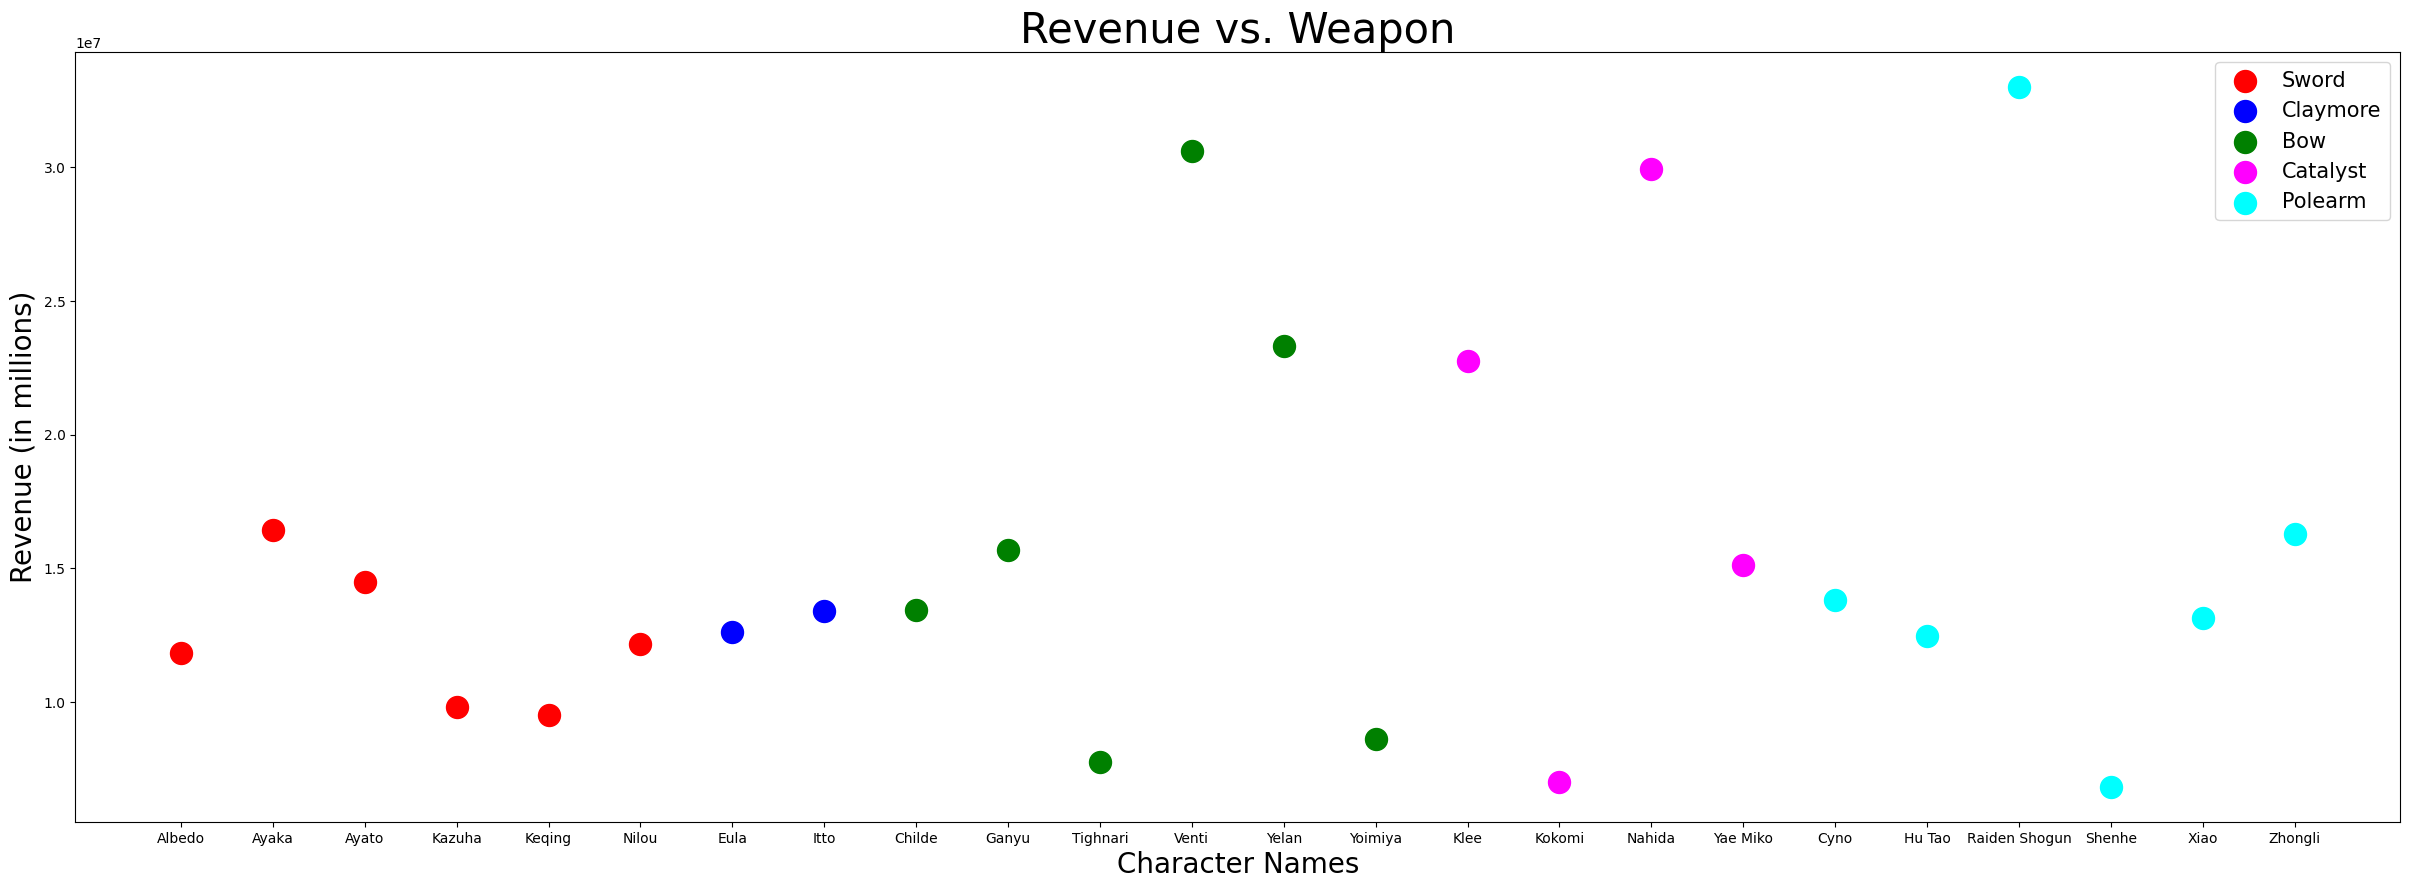

In [14]:
# Scatter plot comparing Weapon and Revenue
sword_names = []
sword_revs = []

claymore_names = []
claymore_revs = []

bow_names = []
bow_revs = []

catalyst_names = []
catalyst_revs = []

polearm_names = []
polearm_revs = []

for row, col in data.iterrows():
    if col['Weapon'] == 'Sword':
        sword_names.append(col['Name'])
        sword_revs.append(col['Revenue Value'])
    elif col['Weapon'] == 'Claymore':
        claymore_names.append(col['Name'])
        claymore_revs.append(col['Revenue Value'])
    elif col['Weapon'] == 'Bow':
        bow_names.append(col['Name'])
        bow_revs.append(col['Revenue Value'])
    elif col['Weapon'] == 'Catalyst':
        catalyst_names.append(col['Name'])
        catalyst_revs.append(col['Revenue Value'])
    else: 
        polearm_names.append(col['Name'])
        polearm_revs.append(col['Revenue Value'])
        
fig, ax = plt.subplots()
fig.set_figwidth(30)
fig.set_figheight(10)

ax.scatter(sword_names, sword_revs, c = 'red', label = 'Sword', s = 250)
ax.scatter(claymore_names, claymore_revs, c = 'blue', label = 'Claymore', s = 250)
ax.scatter(bow_names, bow_revs, c = 'green', label = 'Bow', s = 250)
ax.scatter(catalyst_names, catalyst_revs, c = 'magenta', label = 'Catalyst', s = 250)
ax.scatter(polearm_names, polearm_revs, c = 'cyan', label = 'Polearm', s = 250)

ax.set_title('Revenue vs. Weapon', fontsize = 30)
ax.set_xlabel('Character Names', fontsize = 20)
ax.set_ylabel('Revenue (in millions)', fontsize = 20)
ax.legend(prop = ({'size' : 15}), loc = 1)

plt.show()

### Revenue vs. Years
In the scatterplot below, for each of the unique years we have, the datapoints are scattered. There does not seem to be a correlation between year the character was released and revenue. 

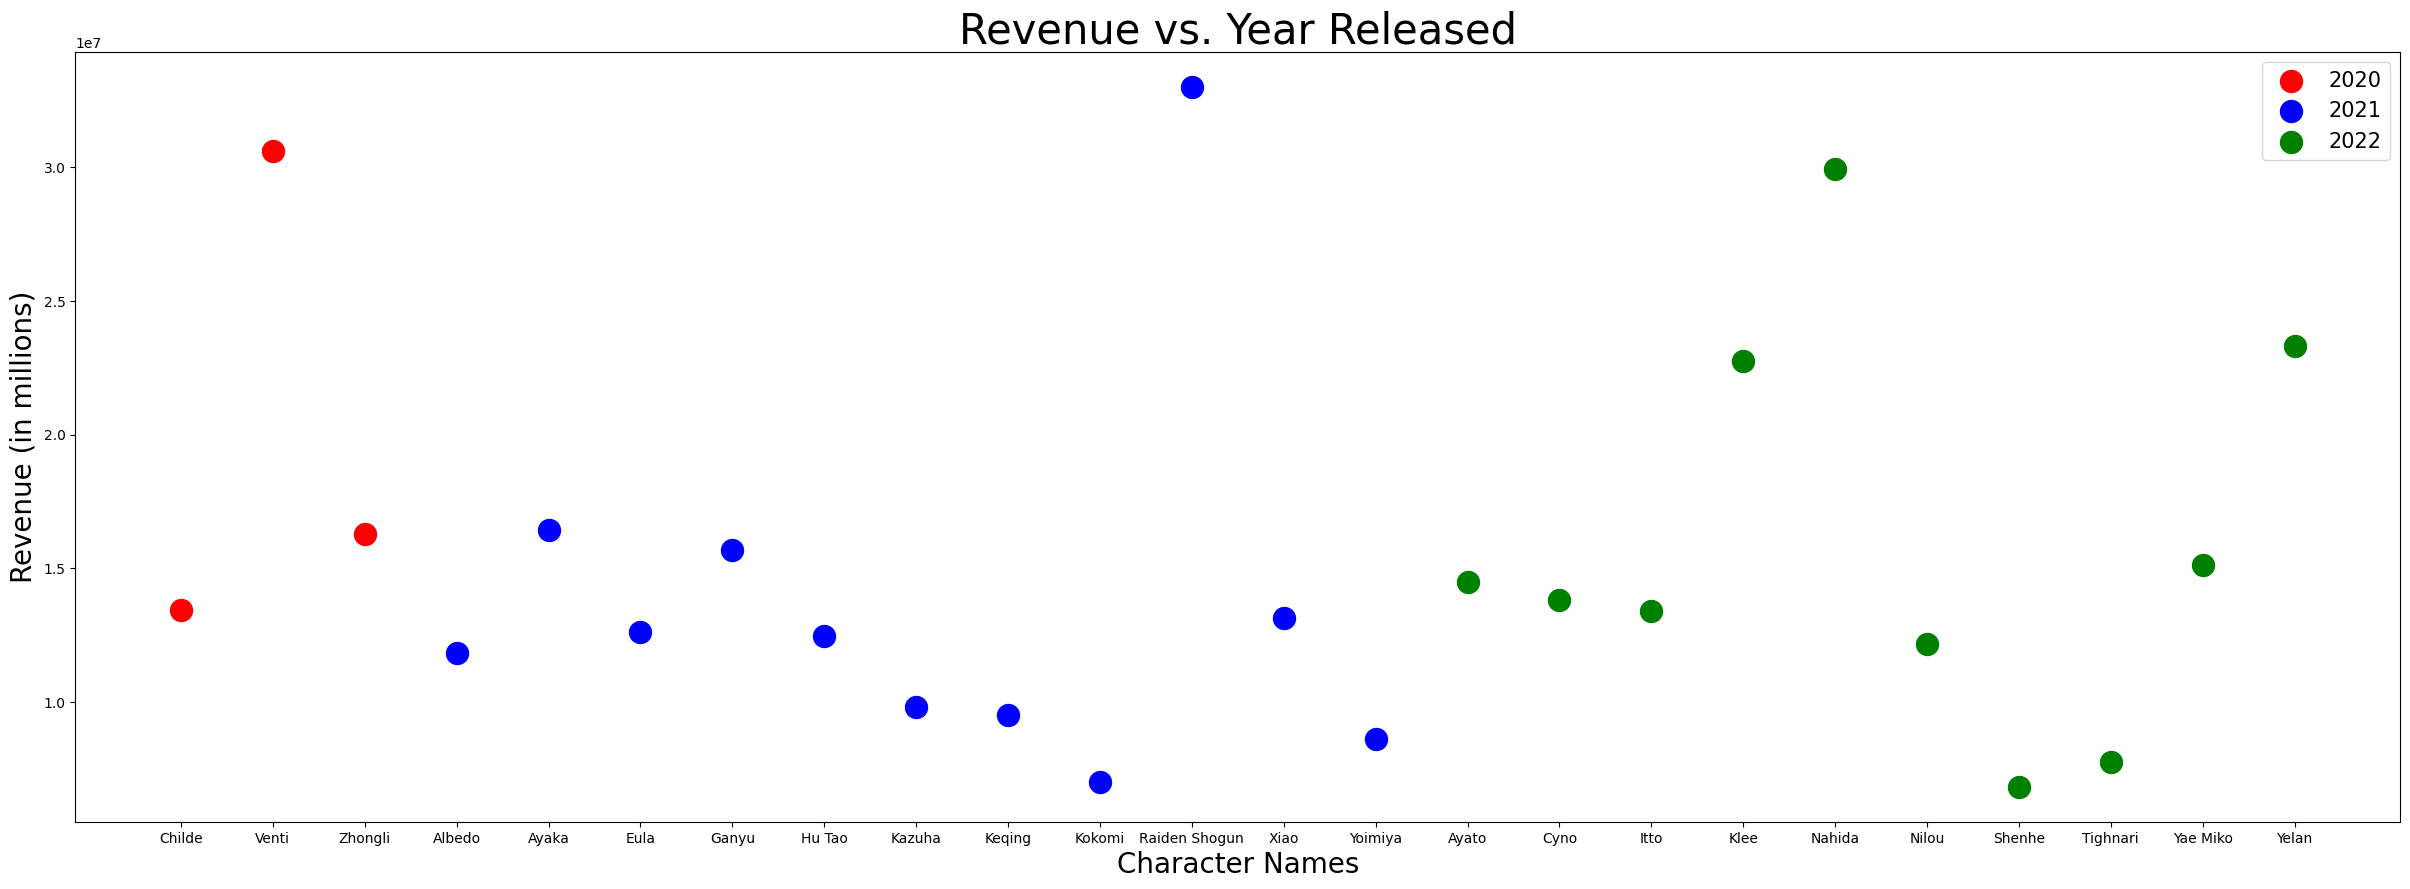

In [15]:
# Scatter plot comparing Years and Revenue
twenty_names = []
twenty_revs = []

twentyone_names = []
twentyone_revs = []

twentytwo_names = []
twentytwo_revs = []

for row, col in data.iterrows():
    if col['Year Released'] == 2020:
        twenty_names.append(col['Name'])
        twenty_revs.append(col['Revenue Value'])
    elif col['Year Released'] == 2021:
        twentyone_names.append(col['Name'])
        twentyone_revs.append(col['Revenue Value'])
    else: 
        twentytwo_names.append(col['Name'])
        twentytwo_revs.append(col['Revenue Value'])
        
fig, ax = plt.subplots()
fig.set_figwidth(30)
fig.set_figheight(10)

ax.scatter(twenty_names, twenty_revs, c = 'red', label = '2020', s = 250)
ax.scatter(twentyone_names, twentyone_revs, c = 'blue', label = '2021', s = 250)
ax.scatter(twentytwo_names, twentytwo_revs, c = 'green', label = '2022', s = 250)

ax.set_title('Revenue vs. Year Released', fontsize = 30)
ax.set_xlabel('Character Names', fontsize = 20)
ax.set_ylabel('Revenue (in millions)', fontsize = 20)
ax.legend(prop = ({'size' : 15}), loc = 1)

plt.show()

### Correlation coefficients
In order to solidify the speculations we made using the above scatterplots, we generated correlation coefficients for each of the features and the years. In order to do this, we first classified the revenue data into two categories, 0 or 1. If the revenue was less than or equal to $15.4M (the average revenue), then it was classified as 0. Otherwise, all the revenue greater than $15.4M was classified as 1. 
<br>Just like the revenue classification, we classified each of the unique elements in each of the features with a different number. After converting categorical data to numerical data using classifications, we used the corr() function to calculate the correlation between each of the features and the revenue. The results are shown and explained below. 

In [16]:
# using the mean revenue a character made, we divided the data into 2 classifications 
# each classification represents below $15.4M (0) and above or equal to $15.4M (1)
for row, col in data.iterrows():
    if col['Revenue Value'] <= mean:
        data.at[row, 'Revenue Classifier'] = 0
    else:
        data.at[row, 'Revenue Classifier'] = 1

data.head()

,Name,Region,Vision,Weapon,Revenue,Year Released,Revenue Value,Revenue Classifier
0,Albedo,Mondstadt,Geo,Sword,"$11,816,107",2021,11816107,0.0
1,Ayaka,Inazuma,Cryo,Sword,"$16,451,006",2021,16451006,1.0
2,Ayato,Inazuma,Hydro,Sword,"$14,481,796",2022,14481796,0.0
3,Childe,Liyue,Hydro,Bow,"$13,443,619",2020,13443619,0.0
4,Cyno,Sumeru,Electro,Polearm,"$13,797,833",2022,13797833,0.0


### Region vs. Revenue correlation
We encoded the regions into 4 different classifications: 0, 1, 2, 3. Since we converted categorical data to numerical data, we can now compare the region and the revenue using the corr() function. The result is -0.1846372364689991. Because the correlation coefficient is so close to 0, we can conclude that there exists no relation between region and the revenue generated by the character. 

In [17]:
# Proving the graphs above have a small correlation
for row, col in data.iterrows():
    if col['Region'] == 'Mondstadt':
        data.at[row, 'Region Encoding'] = 0
    elif col['Region'] == 'Liyue':
        data.at[row, 'Region Encoding'] = 1
    elif col['Region'] == 'Inazuma':
        data.at[row, 'Region Encoding'] = 2
    else:
        data.at[row, 'Region Encoding'] = 3

print(data['Region Encoding'].corr(data['Revenue Classifier']))

-0.1846372364689991


### Vision vs. Revenue Correlation
We classified the visions as 0-6. Since we converted visions from categorical data to numerical data, we can compare them using corr() function. The result we got is: 0.048412291827592706. Since the correlation coefficient is so close to 0, we can conclude that there exists no correlation between vision and revenue. 

In [18]:
for row, col in data.iterrows():
    if col['Vision'] == 'Anemo':
        data.at[row, 'Vision Encoding'] = 0
    elif col['Vision'] == 'Geo':
        data.at[row, 'Vision Encoding'] = 1
    elif col['Vision'] == 'Pyro':
        data.at[row, 'Vision Encoding'] = 2
    elif col['Vision'] == 'Hydro':
        data.at[row, 'Vision Encoding'] = 3
    elif col['Vision'] == 'Cryo':
        data.at[row, 'Vision Encoding'] = 4
    elif col['Vision'] == 'Electro':
        data.at[row, 'Vision Encoding'] = 5
    else:
        data.at[row, 'Vision Encoding'] = 6

print(data['Vision Encoding'].corr(data['Revenue Classifier']))

0.048412291827592706


### Weapon vs. Revenue Correlation
We classified the weapons as 0-4. Since we converted the weapons' data from categorical to numerical data, we can compare weapons and the revenue. The result we got was: 0.19672236884115846. Since the number is closer to 0, we can conclude that there is little to no correlation between the weapon and revenue that the character generated. 

In [19]:
for row, col in data.iterrows():
    if col['Weapon'] == 'Sword':
        data.at[row, 'Weapon Encoding'] = 0
    elif col['Weapon'] == 'Claymore':
        data.at[row, 'Weapon Encoding'] = 1
    elif col['Weapon'] == 'Bow':
        data.at[row, 'Weapon Encoding'] = 2
    elif col['Weapon'] == 'Catalyst':
        data.at[row, 'Weapon Encoding'] = 3
    else:
        data.at[row, 'Weapon Encoding'] = 4

print(data['Weapon Encoding'].corr(data['Revenue Classifier']))

0.19672236884115846


### Year vs. Revenue Correlation
We encoded the year values as 0-2. Since we changed the years' data from categorical data to numerical data, we can compare the years and the revenue using the corr() function. The result was: -0.17440828807877892. Since the number if closer to 0, we can conclude that there is no correlation between the year the character was released and the revenue it made. 

In [20]:
for row, col in data.iterrows():
    if col['Year Released'] == 2020:
        data.at[row, 'Year Encoding'] = 0
    elif col['Year Released'] == 2021:
        data.at[row, 'Year Encoding'] = 1
    else:
        data.at[row, 'Year Encoding'] = 2

print(data['Year Encoding'].corr(data['Revenue Classifier']))

-0.17440828807877892


### External factors analysis conclusion
As we can see from the comments and explanation above, there is no correlation between any of the features or the year they were released. This shows that the revenue that is generated by these characters is hugely based on the aesthetic of it. Since we took away any of the other factor that could play a role in generating the revenue, we can conclude that we can use the image to predict the classification of revenue a character will fall into. So, our analysis from here on focuses on the images of the character. 

In [21]:
# given the filepath to the image, we can visualize the image
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

In [22]:
# transformations using albumentations library
vertical_transform = A.Compose([A.VerticalFlip(p=1)])
horizontal_transform = A.Compose([A.HorizontalFlip(p=1)])

### Model and Transfer Learning
Now, we can start the preprocessing required to feed the data into the model. For this step, we go through all the images in the "character images" folder. We then extract the character name, and create our file path for each image correctly. Next, we read in the colored images, and resize all of them to standardize them to a certain size of (100,250). Lastly, we convert all the pixels to numerical data. <br> One of our main concerns was that our dataset was very small as there were a limited number of characters. We solved this problem by applying image augmentations. We applied a horizontal and vertical transform to each image, thereby tripling the size of our dataset. We could now add all of our images, and our revenue to our images_arr, and our revenue_arr.<br> In our last few steps of preprocessing, we convert our images and revenues to np.array of type float and int32 respectively. <br> Now we can split out data into training and testing sets!

In [23]:
images_arr = [] # array of images
revenue_arr = [] # array of revenues for each character
counter = 0

# iterates over the character images in the folder 
# returns a tuple where the 3rd element is a list of the character names
for e_image in os.walk('./Genshin Characters/'):

    # iterates over the list of the character names
    for img_name in e_image[2]:
        file_path = './Genshin Characters/{}'.format(img_name)
        image = cv2.imread(file_path) # converts the image to color
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (100, 250)) # resizing images to same size
        
        # the following code changes pixels to numeric data
        image = np.array(image)
        image = image.astype('float32')
        image /= 255
        
        # transform function takes in the image as the parameter
        # the output is a dictionary with 'image' as the key and the transformed image as the value
        # so, we extract the value by giving it the key
        vertical_image = vertical_transform(image=image)['image'] 
        horizontal_image = horizontal_transform(image=image)['image']
       
        images_arr.append(image)
        images_arr.append(vertical_image)
        images_arr.append(horizontal_image)
        
        revenue_arr.append(data['Revenue Classifier'][counter])
        revenue_arr.append(data['Revenue Classifier'][counter])
        revenue_arr.append(data['Revenue Classifier'][counter])
        counter += 1

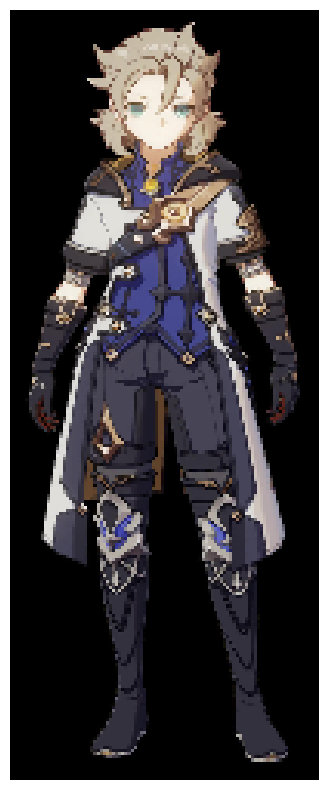

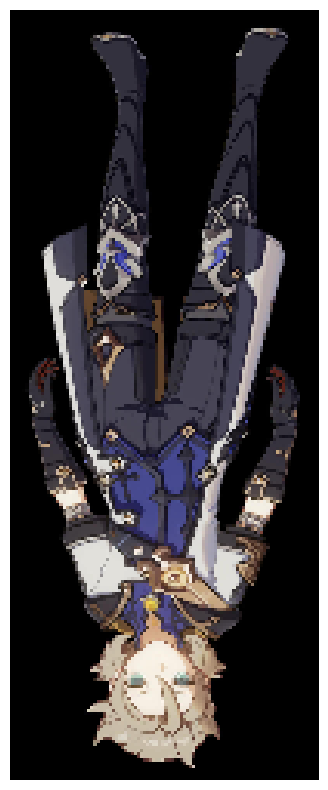

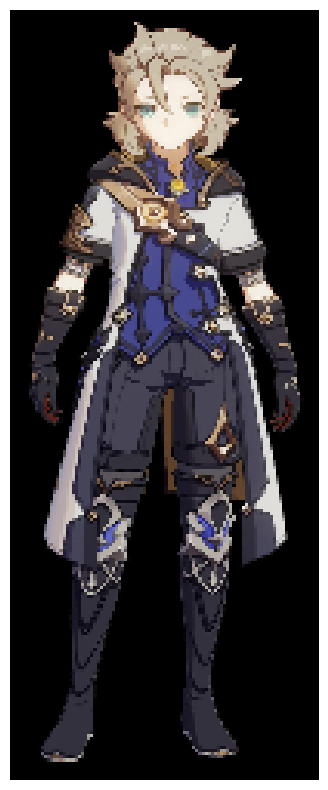

In [24]:
for image in images_arr[:3]:
    visualize(image)

In [25]:
print(len(revenue_arr))
print(len(images_arr))

72
72


In [26]:
images_arr = np.array(images_arr).astype(np.float32)

In [27]:
# converting all the revenues to type np.int32 
revenue_arr = list(map(lambda x: x.astype(np.int32), revenue_arr))

In [28]:
# splitting our data into training and testing sets
img_train, img_test, rev_train, rev_test = train_test_split(images_arr, revenue_arr, test_size=0.2, 
                                                            shuffle = True, random_state = 20)

In [29]:
img_train.shape

(57, 250, 100, 3)

### Transfer Learning
We chose to use transfer learning for several reasons:<br>
1) Our dataset has characters that our model has not seen before. Therefore, we take features learned on the imagenet dataset and leverage them for our problem. <br>
2) Our dataset has very little data to train a full scale model from scratch. <br><br> The main steps we need to follow for transfer learning is to:
*   Take layers from a previously trained model
*   Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
*   Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
*  Train the new layers on our dataset.<br><br>For our transfer learning section of the project, we first built a base model using keras.applications.Xception. We then load the pretrained weights from imagenet. We add a Dropout layer before the classification layer, for regularization. Further, we also add a global pooling layer. We also make sure to pass training=False when calling the base model, so that it runs in inference mode, so that batchnorm statistics don't get updated even after we unfreeze the base model for fine-tuning.<br>We then train the top layer of the model where we compile and fit our model. In our case, we got a high accuracy of 96% after running it on 20 epochs, therefore we did not need to finetune it anymore. We can see that transfer learning was extremely useful and perfect for our classification task as we could pull out the features as vectors from a base model and use them for training the model on our dataset. 




In [30]:
base_model = keras.applications.Xception (
    weights = 'imagenet',
    input_shape = (250, 100, 3),
    include_top = False
)

83683744/83683744 [==============================] - 11s 0us/step


In [31]:
base_model.trainable = False

In [32]:
inputs = keras.Input(shape = (250, 100, 3))
x = base_model(inputs, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


In [33]:
model.compile(optimizer=keras.optimizers.Adam(), loss = keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics = [keras.metrics.BinaryAccuracy()])

In [34]:
print(len(rev_train))
print(len(img_train))

57
57


In [35]:
model.fit(img_train, np.array(rev_train), epochs = 5, validation_data = (img_test, np.array(rev_test)))

Epoch 1/5
2/2 [==============================] - 11s 5s/step - loss: 0.7896 - binary_accuracy: 0.4912 - val_loss: 0.5984 - val_binary_accuracy: 0.8000
Epoch 2/5
2/2 [==============================] - 9s 5s/step - loss: 0.6480 - binary_accuracy: 0.5965 - val_loss: 0.4958 - val_binary_accuracy: 0.8000
Epoch 3/5
2/2 [==============================] - 9s 5s/step - loss: 0.6391 - binary_accuracy: 0.6316 - val_loss: 0.4774 - val_binary_accuracy: 0.8000
Epoch 4/5
2/2 [==============================] - 10s 5s/step - loss: 0.6357 - binary_accuracy: 0.6316 - val_loss: 0.4711 - val_binary_accuracy: 0.8000
Epoch 5/5
2/2 [==============================] - 10s 5s/step - loss: 0.5989 - binary_accuracy: 0.6316 - val_loss: 0.4790 - val_binary_accuracy: 0.8000


In [38]:
#file_path = './wanderer.jpg'
#image = cv2.imread(file_path) # converts the image to color
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = cv2.resize(image, (100, 250)) # resizing images to same size
        
# the following code changes pixels to numeric data
#image = np.array(image)
#mage = image.astype('float32')
#image /= 255
#model.predict(image)